<div class='alert alert-success'>
    <h1 align="center">Chapter 7: SVM and Model Selection</h1> 
    <h3 align="center">Machine Learning Course (Fall 2018)</h3>
    <h5 align="center">Seyed Naser RAZAVI <a href='http://www.snrazavi.ir/ml-2018/'>ML2018</a></h5>
</div>


## Introduction


- Non-linear classification using SVM and gaussian kernels
- Model selection: determining the values of the hyper-parameters
- Validation and cross validation
- K-Fold cross validation
- Stratified K-fold cross validation
- Grid search

In [1]:
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatLogSlider, Checkbox

from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import seaborn as sns; sns.set()

from utils import *

## Spiral Dataset

<IPython.core.display.Javascript object>


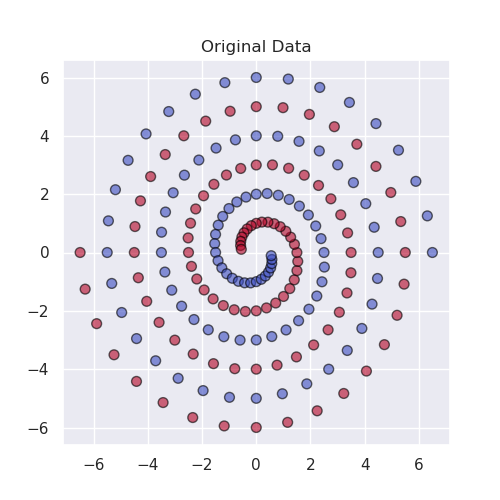

In [5]:
X, y = make_spirals()

# Plot spirals
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolors='black', cmap=plt.cm.coolwarm, alpha=0.6)
plt.title("Original Data")
plt.show()

### Non-linear SVM using Gaussian Kernels (RBF)

<IPython.core.display.Javascript object>


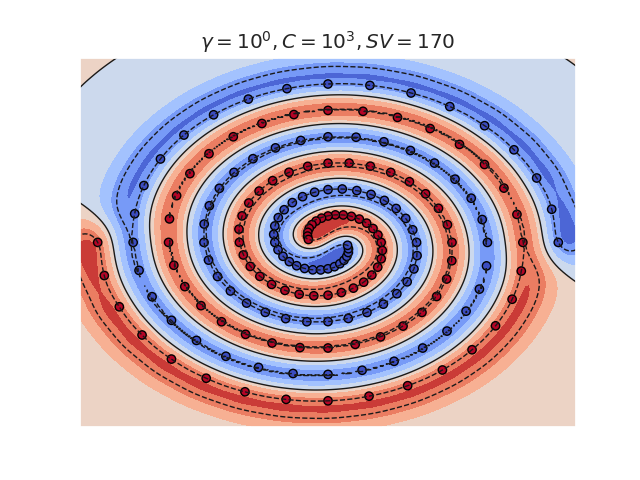

interactive(children=(FloatLogSlider(value=10.0, description='C:', max=5.0, min=-3.0, step=1.0), FloatLogSlide…

In [7]:
fig, ax = plt.subplots(1)

X1, X2 = np.meshgrid(np.linspace(-7, 7, 200), np.linspace(-7, 7, 200))

def update_plot(C, gamma, show_svs, show_levels):
    ax.clear()
    
    # create and train SVM classifier
    clf = SVC(C=C, gamma=gamma)
    clf.fit(X, y)
    sv = clf.support_vectors_
    
    # compute contours
    Z = clf.decision_function(np.c_[X1.ravel(), X2.ravel()])
    Z = Z.reshape(X1.shape)

    # visualize parameter's effect on decision function
    ax.contourf(X1, X2, Z, cmap=plt.cm.coolwarm)
    
    # plot decision boundaries
    if show_levels:
        ax.contour(X1, X2, Z, linewidths=1, colors='k', levels=[-1, 0, 1], linestyles=['--', '-', '--'])
    
    # plot data
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='black', cmap=plt.cm.coolwarm, alpha=1.0)
    
    # plot support vectors
    if show_svs:
        sv = clf.support_vectors_
        ax.scatter(sv[:, 0], sv[:, 1], s=150, facecolors='none', edgecolors='k')
    
    title = "$\gamma = 10^{:1.0g}, C = 10^{:1.0g}, SV = {:d}$"
    ax.set_title(title.format(np.log10(gamma), np.log10(C), len(sv)), size='large')
    ax.set_xticks(())
    ax.set_yticks(())
    plt.show()


C = FloatLogSlider(value=10, base=10, min=-3, max=5, step=1, description='C:')
gamma = FloatLogSlider(value=1, base=10, min=-3, max=5, step=1, description='gamma:')
show_svs = Checkbox(value=False, description='Show Support Vectors')
show_levels = Checkbox(value=True, description='Show Levels')

f = interact(update_plot, C=C, gamma=gamma, show_svs=show_svs, show_levels=show_levels)

### Split data for validation: K-Fold cross validation

In [4]:
X1 = np.random.randn(10, 2)

cv = KFold(n_splits=5)

for train_idx, val_idx in cv.split(X1):
    print("Train = {} | Validation ={}".format(train_idx, val_idx))

Train = [2 3 4 5 6 7 8 9] | Validation =[0 1]
Train = [0 1 4 5 6 7 8 9] | Validation =[2 3]
Train = [0 1 2 3 6 7 8 9] | Validation =[4 5]
Train = [0 1 2 3 4 5 8 9] | Validation =[6 7]
Train = [0 1 2 3 4 5 6 7] | Validation =[8 9]


### Stratified K-Fold cross validation

* This cross-validation object is a variation of KFold that returns stratified folds. 
* The folds are made by preserving the **percentage of samples** for each class.

In [5]:
X1 = np.random.randn(9, 2)
y1 = np.array([0, 0, 0, 1, 1, 1, 1, 1, 1])

cv = StratifiedKFold(n_splits=3)

for trn_idx, val_idx in cv.split(X1, y1):
    print("Train={} | Valid={} | Labels={}, {}".format(trn_idx, val_idx, y1[trn_idx], y1[val_idx]))

Train=[1 2 5 6 7 8] | Valid=[0 3 4] | Labels=[0 0 1 1 1 1], [0 1 1]
Train=[0 2 3 4 7 8] | Valid=[1 5 6] | Labels=[0 0 1 1 1 1], [0 1 1]
Train=[0 1 3 4 5 6] | Valid=[2 7 8] | Labels=[0 0 1 1 1 1], [0 1 1]


So, why we did not use KFold in the last example? What is the problem?

In [10]:
X1 = np.random.randn(9, 2)
y1 = np.array([0, 0, 0, 1, 1, 1, 1, 1, 1])

cv = KFold(n_splits=3)

for trn_idx, val_idx in cv.split(X1, y1):
    print("Train={} | Valid={} | Labels={}, {}".format(trn_idx, val_idx, y1[trn_idx], y1[val_idx]))

Train=[3 4 5 6 7 8] | Valid=[0 1 2] | Labels=[1 1 1 1 1 1], [0 0 0]
Train=[0 1 2 6 7 8] | Valid=[3 4 5] | Labels=[0 0 0 1 1 1], [1 1 1]
Train=[0 1 2 3 4 5] | Valid=[6 7 8] | Labels=[0 0 0 1 1 1], [1 1 1]


### Train classifiers

 - For an initial search, a logarithmic grid with basis 10 is often helpful. 
 - Using a basis of 2, a finer tuning can be achieved but at a much higher cost.

In [11]:
# 1: split data to train and validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2: specify range of hyper-parameters
C_range = np.logspace(-3, 5, 9)         # 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5
gamma_range = np.logspace(-3, 5, 9)     # 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5
param_grid = dict(gamma=gamma_range, C=C_range)

# 3: create classifier
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)

# 4: Train
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 10.0, 'gamma': 1.0} with a score of 0.83


<IPython.core.display.Javascript object>


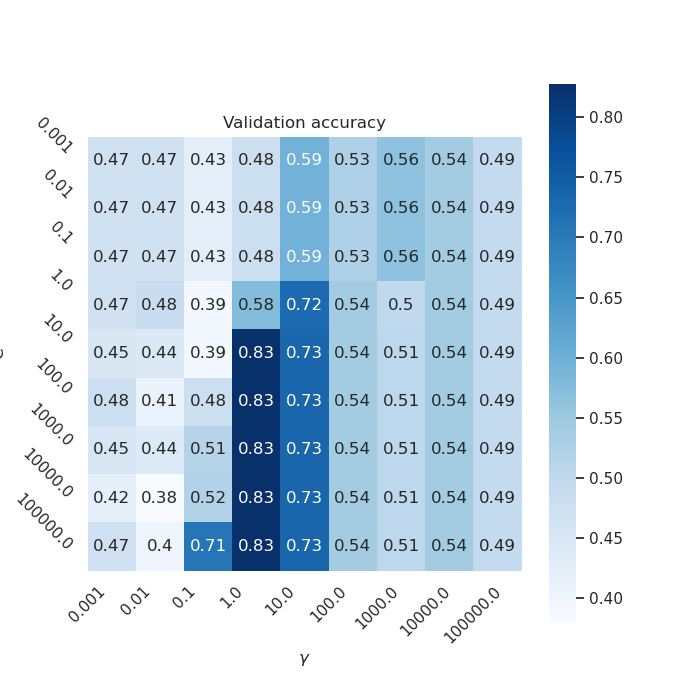

In [12]:
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))

plt.figure(figsize=(7, 7))

# Draw heatmap of the validation accuracy as a function of gamma and C
sns.heatmap(scores, annot=True, cmap='Blues', square=True)

plt.xlabel('$\gamma$')
plt.ylabel('C')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range, rotation=-45)
plt.title('Validation accuracy')
plt.show()

### Visualization

draw visualization of parameter effects

In [9]:
C_range = [0.1, 10, 1000]
gamma_range = [0.1, 1, 10]

classifiers = []

for C in C_range:
    for gamma in gamma_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X, y)
        classifiers.append((clf, C, gamma))

<IPython.core.display.Javascript object>


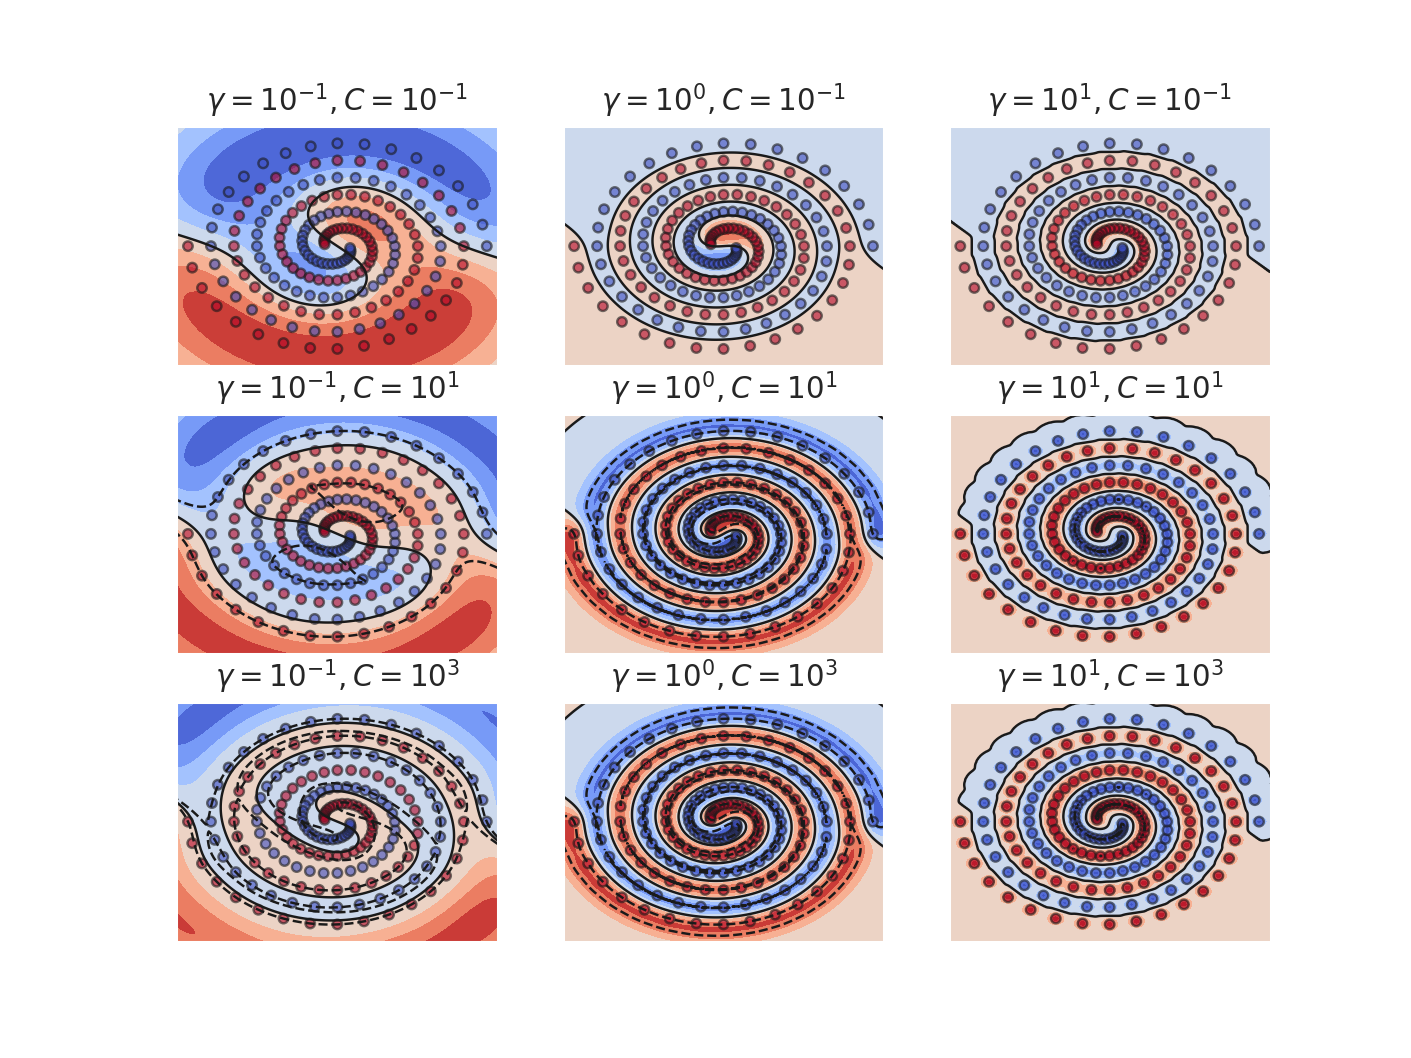

In [10]:
plt.figure(figsize=(8, 6))

X1, X2 = np.meshgrid(np.linspace(-7, 7, 200), np.linspace(-7, 7, 200))

for i, (clf, C, gamma) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[X1.ravel(), X2.ravel()])
    Z = Z.reshape(X1.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_range), len(gamma_range), i + 1)
    plt.title("$\gamma = 10^{%d}, C = 10^{%d}$" % (np.log10(gamma), np.log10(C)))

    # visualize parameter's effect on decision function
    plt.contourf(X1, X2, Z, cmap=plt.cm.coolwarm)
    plt.contour(X1, X2, Z, linewidths=1, colors='k', levels=[-1, 0, 1], linestyles=['--', '-', '--'])
    plt.scatter(X[:, 0], X[:, 1], s=15, c=y, edgecolors='k', cmap=plt.cm.coolwarm, alpha=0.6)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')
    
plt.show()